In [ ]:
print('Hello')

Hello


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 674M/675M [00:42<00:00, 22.3MB/s]
100% 675M/675M [00:42<00:00, 16.7MB/s]


In [ ]:
!mkdir Datasets

importing needy modules

In [ ]:
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.utils import image_dataset_from_directory , plot_model
from keras.models import Sequential , Model

In [ ]:
with ZipFile('/content/cell-images-for-detecting-malaria.zip') as fp:
  fp.extractall('/content/Datasets')

In [ ]:
print(len(os.listdir('/content/Datasets/cell_images/Parasitized')))
print(len(os.listdir('/content/Datasets/cell_images/cell_images/Parasitized')))

13780
13780


In [ ]:
shutil.rmtree('/content/Datasets/cell_images/cell_images')

Uninfected ::: --------


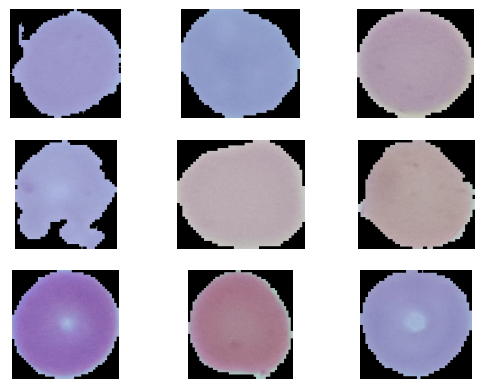

Parasitized ::: -------


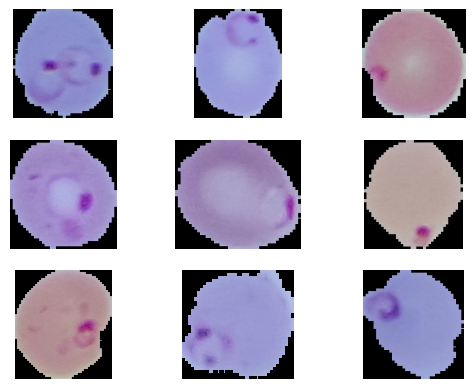

In [ ]:
### visualizing files
l1 = os.listdir('/content/Datasets/cell_images/Parasitized')
l2 = os.listdir('/content/Datasets/cell_images/Uninfected')

print('Uninfected ::: --------')
for i in range(9):
  img = cv2.imread(os.path.join('/content/Datasets/cell_images/Uninfected' , l2[i]))
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')


plt.show()

print('Parasitized ::: -------')
for i in range (9):
  img = cv2.imread(os.path.join('/content/Datasets/cell_images/Parasitized' , l1[i]))
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')


plt.show()



In [ ]:
def img_resize(img , lbl , tsize):
  img = tf.image.resize(img , tsize)
  return img , lbl;


agum = Sequential([
    RandomBrightness(0.1),
    RandomContrast(0.2),
    RandomFlip(),
    RandomRotation(0.4 , fill_mode='nearest')

])

def train_process(img , lbl):
  img = agum(img)
  img = tf.cast(img/255. , tf.float32)
  return img , lbl;

def val_process(img , lbl):
  img = tf.cast(img/255. , tf.float32)
  return img , lbl;
## creating ds ----

def custom_ds(tsize):
  train_ds = image_dataset_from_directory(
      '/content/Datasets/cell_images',
      batch_size=32,
      image_size=(96,96),
      seed = 124,
      validation_split=0.2,
      subset='training'
  )
  val_ds = image_dataset_from_directory(
      '/content/Datasets/cell_images',
      batch_size=32,
    image_size=(96,96),
    seed = 124,
    validation_split=0.2,
    subset='validation'
  )



  train_ds = train_ds.map(lambda x , y: img_resize(x,y,tsize))
  train_ds = train_ds.map(train_process)
  val_ds = val_ds.map(lambda x, y : img_resize(x,y , tsize))
  val_ds = val_ds.map(val_process)
  return train_ds , val_ds

In [ ]:
train_96 , val_96= custom_ds((96,96))

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [ ]:
def adjust_shape(image, label):
    image_96 = tf.image.resize(image, (96,96))
    image_64 = tf.image.resize(image, (64,64))
    image_32 = tf.image.resize(image, (32, 32))
    image_28 = tf.image.resize(image, (28, 28))
    return (image_96, image_64, image_32, image_28), label

adjusted_dataset = train_96.map(adjust_shape)
val_ds = val_96.map(adjust_shape)

In [ ]:

# Define CNN block
def cnn_block(input_layer):
    x = Conv2D(26, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x=Conv2D(32 , (2,2) , activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)
    x=Conv2D(64 , (2,2) , activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = RepeatVector(2)(x)
    return x

# Create inputs for different image shapes
input_96= Input(shape=(96,96, 3))
input_64 = Input(shape=(64, 64, 3))
input_32 = Input(shape=(32, 32, 3))
input_28 = Input(shape=(28,28 , 3))

# Create CNN blocks for each input
cnn_96 = cnn_block(input_96)
cnn_64 = cnn_block(input_64)
cnn_32 = cnn_block(input_32)
cnn_28 = cnn_block(input_28)

# Combine the outputs of the CNN blocks
combined = concatenate([cnn_96, cnn_64, cnn_32 , cnn_28])

# Add a fully connected layer and output layer
x = LSTM(128, activation='relu', return_sequences=False)(combined)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[input_96, input_64, input_32 , input_28], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],run_eagerly=True)

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                            

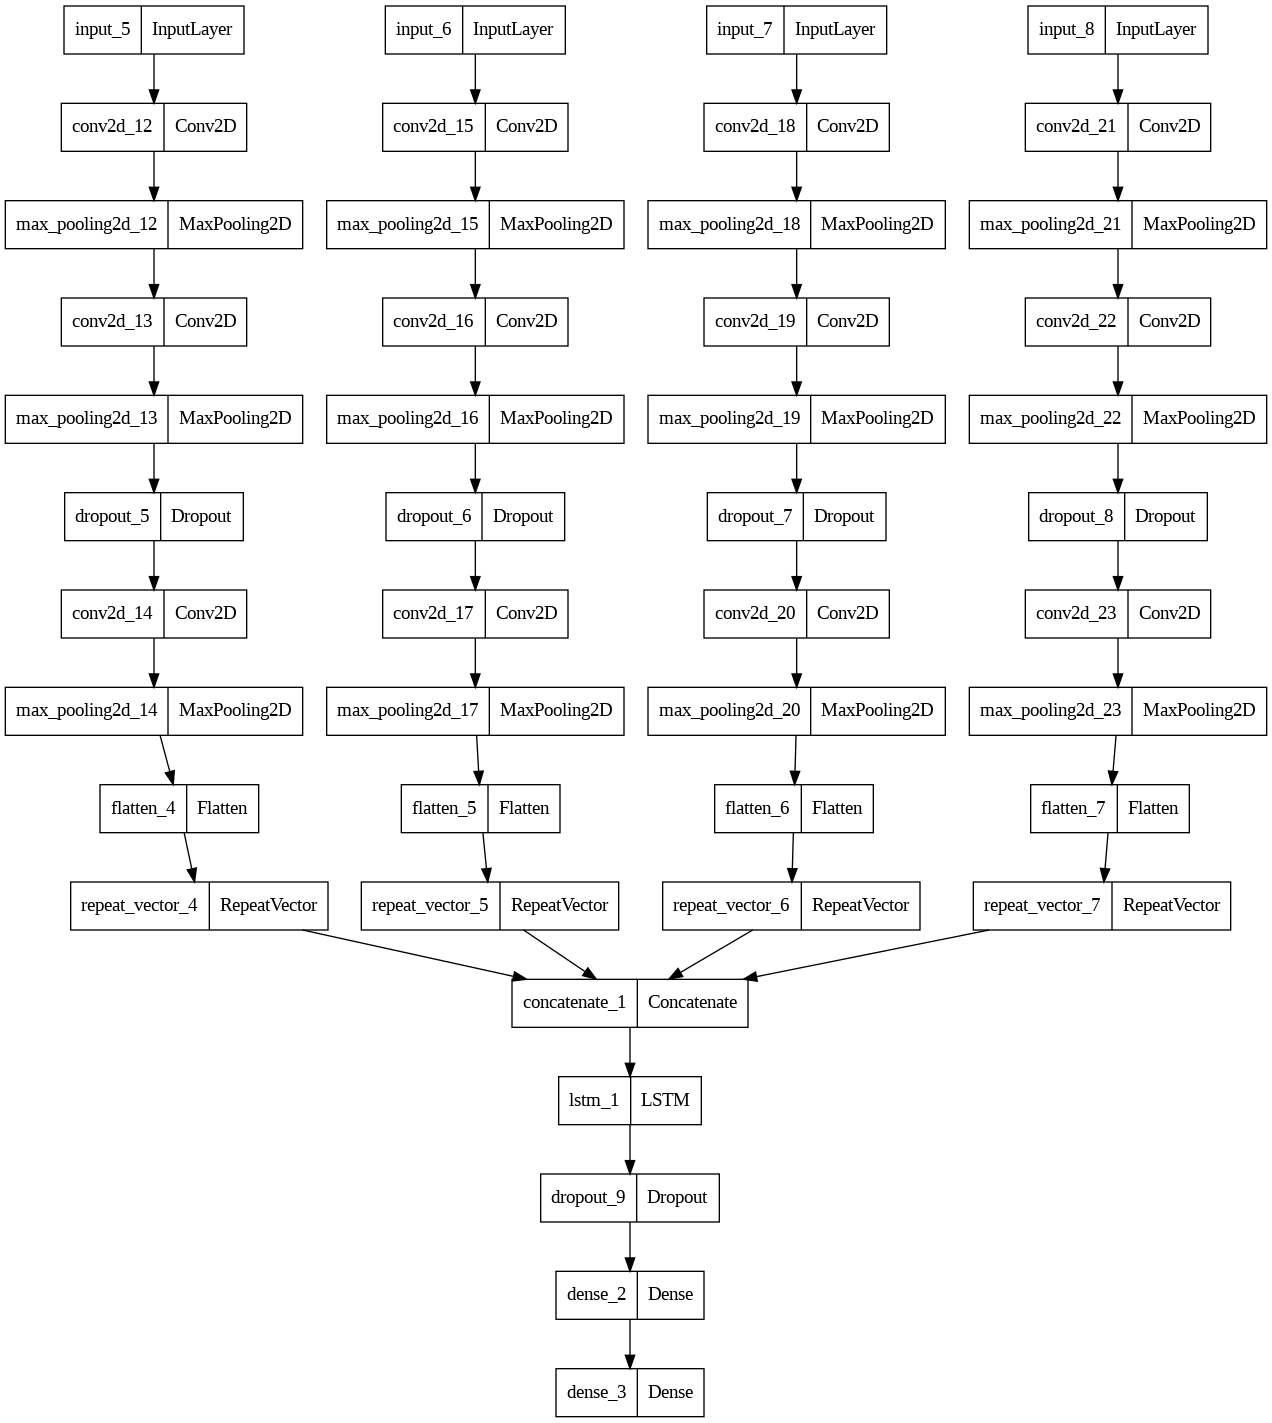

In [ ]:
plot_model(model)

In [ ]:
history = model.fit(adjusted_dataset , epochs=25 , verbose=1 , validation_data=val_ds)

Epoch 1/25
689/689 [==============================] - 114s 161ms/step - loss: 0.4415 - accuracy: 0.7766 - val_loss: 0.2081 - val_accuracy: 0.9274
Epoch 2/25
689/689 [==============================] - 109s 158ms/step - loss: 0.1974 - accuracy: 0.9380 - val_loss: 0.1553 - val_accuracy: 0.9528
Epoch 3/25
689/689 [==============================] - 112s 162ms/step - loss: 0.1726 - accuracy: 0.9465 - val_loss: 0.1724 - val_accuracy: 0.9465
Epoch 4/25
689/689 [==============================] - 109s 158ms/step - loss: 0.1533 - accuracy: 0.9507 - val_loss: 0.1514 - val_accuracy: 0.9554
Epoch 5/25
689/689 [==============================] - 109s 158ms/step - loss: 0.1493 - accuracy: 0.9524 - val_loss: 0.1575 - val_accuracy: 0.9483
Epoch 6/25
689/689 [==============================] - 111s 161ms/step - loss: 0.1457 - accuracy: 0.9538 - val_loss: 0.1434 - val_accuracy: 0.9583
Epoch 7/25
689/689 [==============================] - 109s 158ms/step - loss: 0.1435 - accuracy: 0.9539 - val_loss: 0.1394 -

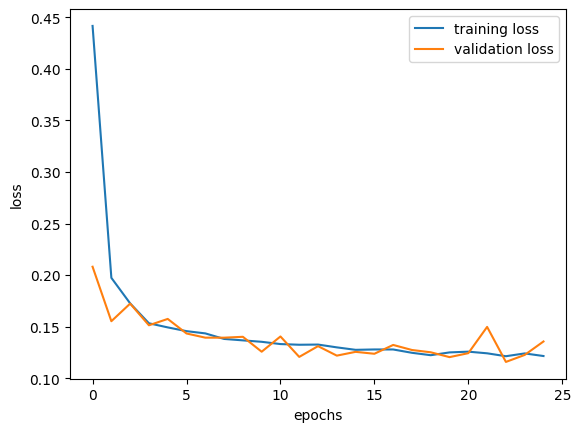

In [ ]:

plt.plot(history.history['loss'] , label='training loss')
plt.plot(history.history['val_loss'] , label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

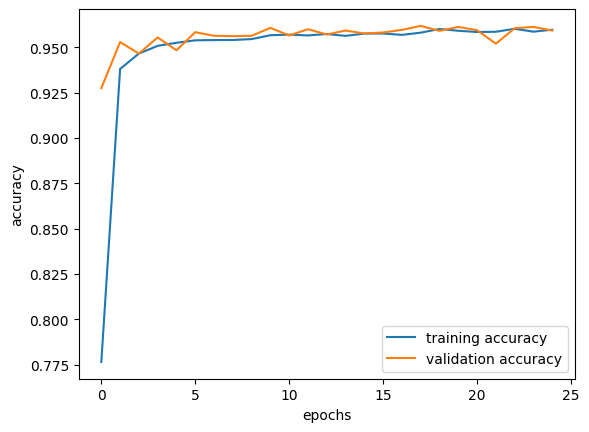

In [ ]:
plt.plot(history.history['accuracy'] , label='training accuracy' )
plt.plot(history.history['val_accuracy'] , label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('malaria-cell.keras')